In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from utils import save_as_json, plot_data

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sources = ["acoustic", "electronic", "synthetic"]
families = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]

In [4]:
spectrograms_train = tf.saved_model.load("data/processed/spectrograms_train").read_value()
spectrograms_test = tf.saved_model.load("data/processed/spectrograms_test").read_value()
labels_instr_train = tf.saved_model.load("data/processed/labels_instr_train").read_value()
labels_instr_test = tf.saved_model.load("data/processed/labels_instr_test").read_value()
labels_src_train = tf.saved_model.load("data/processed/labels_src_train").read_value()
labels_src_test = tf.saved_model.load("data/processed/labels_src_test").read_value()
audio_train = tf.saved_model.load("data/processed/audio_train").read_value()
audio_test = tf.saved_model.load("data/processed/audio_test").read_value()
audio_train = tf.expand_dims(audio_train, axis=-1)
audio_test = tf.expand_dims(audio_test, axis=-1)

In [5]:
print(spectrograms_train.shape)
print(labels_instr_train.shape)
print(spectrograms_test.shape)
print(labels_instr_test.shape)
print(audio_train.shape)
print(audio_test.shape)

(3072, 499, 129, 1)
(3072,)
(1024, 499, 129, 1)
(1024,)
(3072, 64000, 1)
(1024, 64000, 1)


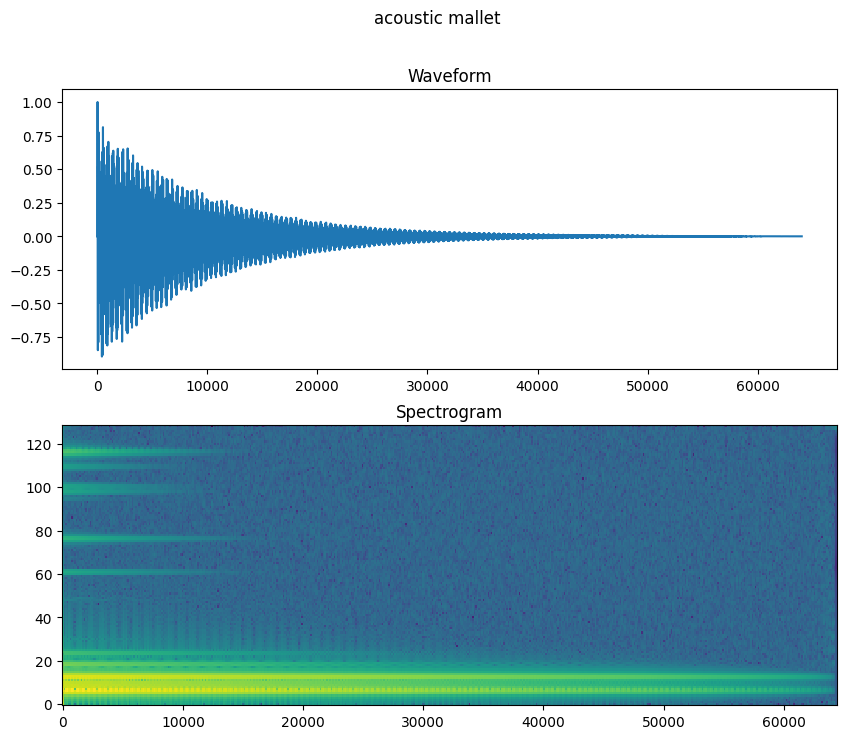

In [9]:
plot_data(audio_train[100], spectrograms_train[100], sources[labels_src_train[100]], families[labels_instr_train[100]])

In [6]:
model_instr_cnn = models.Sequential([
    layers.Input(shape=(None, None, 1)),
    layers.Resizing(*spectrograms_train.shape[1:-1]),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(len(families)),
])

model_instr_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 499, 129, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 497, 127, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 248, 63, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 246, 61, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 30, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 28, 64)       1

In [7]:
model_instr_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [8]:
EPOCHS = 50
history = model_instr_cnn.fit(
    x=spectrograms_train,
    y=labels_instr_train,
    validation_data=(spectrograms_test, labels_instr_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
96/96 [==============================] - 97s 145ms/step - loss: 1.6074 - accuracy: 0.4590 - val_loss: 1.1048 - val_accuracy: 0.5967
Epoch 2/50
96/96 [==============================] - 5s 50ms/step - loss: 0.8563 - accuracy: 0.6947 - val_loss: 0.6303 - val_accuracy: 0.8037
Epoch 3/50
96/96 [==============================] - 5s 50ms/step - loss: 0.5816 - accuracy: 0.8018 - val_loss: 0.5256 - val_accuracy: 0.8223
Epoch 4/50
96/96 [==============================] - 5s 50ms/step - loss: 0.4279 - accuracy: 0.8493 - val_loss: 0.3786 - val_accuracy: 0.8818
Epoch 5/50
96/96 [==============================] - 5s 49ms/step - loss: 0.3247 - accuracy: 0.8906 - val_loss: 0.2638 - val_accuracy: 0.9248
Epoch 6/50
96/96 [==============================] - 5s 50ms/step - loss: 0.2782 - accuracy: 0.9072 - val_loss: 0.4317 - val_accuracy: 0.8955
Epoch 7/50
96/96 [==============================] - 5s 49ms/step - loss: 0.2617 - accuracy: 0.9176 - val_loss: 0.3364 - val_accuracy: 0.9131
Epoch 8/50


In [9]:
save_as_json(history.history, "training_history/instr_cnn.json")
model_instr_cnn.save("./models/instr_cnn")

INFO:tensorflow:Assets written to: ./models/instr_cnn\assets


INFO:tensorflow:Assets written to: ./models/instr_cnn\assets


In [7]:
model_instr_lr = models.Sequential([
    layers.Input(shape=(None, None, 1)),
    layers.Resizing(*spectrograms_train.shape[1:-1]),
    layers.Flatten(),
    layers.Dense(len(families)),
])

model_instr_lr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 499, 129, 1)       0         
                                                                 
 flatten (Flatten)           (None, 64371)             0         
                                                                 
 dense (Dense)               (None, 11)                708092    
                                                                 
Total params: 708,092
Trainable params: 708,092
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_instr_lr.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [22]:
EPOCHS = 50
history = model_instr_lr.fit(
    x=spectrograms_train,
    y=labels_instr_train,
    validation_data=(spectrograms_test, labels_instr_test),
    epochs=EPOCHS,
)

Epoch 1/50
96/96 [==============================] - 2s 14ms/step - loss: 7.0257 - accuracy: 0.4189 - val_loss: 5.6141 - val_accuracy: 0.4365
Epoch 2/50
96/96 [==============================] - 1s 10ms/step - loss: 3.3819 - accuracy: 0.5938 - val_loss: 5.2932 - val_accuracy: 0.5195
Epoch 3/50
96/96 [==============================] - 1s 10ms/step - loss: 2.4477 - accuracy: 0.6712 - val_loss: 4.7363 - val_accuracy: 0.6113
Epoch 4/50
96/96 [==============================] - 1s 10ms/step - loss: 1.9551 - accuracy: 0.7116 - val_loss: 4.1863 - val_accuracy: 0.6484
Epoch 5/50
96/96 [==============================] - 1s 10ms/step - loss: 1.4949 - accuracy: 0.7487 - val_loss: 3.8463 - val_accuracy: 0.6553
Epoch 6/50
96/96 [==============================] - 1s 10ms/step - loss: 1.3020 - accuracy: 0.7764 - val_loss: 4.1066 - val_accuracy: 0.6543
Epoch 7/50
96/96 [==============================] - 1s 10ms/step - loss: 1.6522 - accuracy: 0.7406 - val_loss: 4.4616 - val_accuracy: 0.6865
Epoch 8/50
96

In [19]:
save_as_json(history.history, "training_history/instr_lr.json")
model_instr_lr.save("./models/instr_lr")

INFO:tensorflow:Assets written to: ./models/instr_lr\assets


INFO:tensorflow:Assets written to: ./models/instr_lr\assets


In [14]:
model_src_cnn = models.Sequential([
    layers.Input(shape=audio_train.shape[1:]),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(len(sources)),
])

model_src_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 63998, 32)         128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 31999, 32)        0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 31997, 64)         6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 15998, 64)        0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15998, 64)         0         
                                                                 
 flatten_3 (Flatten)         (None, 1023872)          

In [15]:
model_src_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [16]:
EPOCHS = 50
history = model_src_cnn.fit(
    x=audio_train,
    y=labels_src_train,
    validation_data=(audio_test, labels_src_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
96/96 [==============================] - 14s 142ms/step - loss: 1.2731 - accuracy: 0.5078 - val_loss: 0.8735 - val_accuracy: 0.6201
Epoch 2/50
96/96 [==============================] - 13s 141ms/step - loss: 0.6611 - accuracy: 0.7067 - val_loss: 0.6509 - val_accuracy: 0.7090
Epoch 3/50
96/96 [==============================] - 14s 146ms/step - loss: 0.4529 - accuracy: 0.8164 - val_loss: 0.5912 - val_accuracy: 0.7549
Epoch 4/50
96/96 [==============================] - 14s 141ms/step - loss: 0.3336 - accuracy: 0.8672 - val_loss: 0.5984 - val_accuracy: 0.7617
Epoch 5/50
96/96 [==============================] - 14s 143ms/step - loss: 0.2207 - accuracy: 0.9242 - val_loss: 0.6249 - val_accuracy: 0.7656
Epoch 6/50
96/96 [==============================] - 14s 143ms/step - loss: 0.1897 - accuracy: 0.9313 - val_loss: 0.7151 - val_accuracy: 0.7656
Epoch 7/50
96/96 [==============================] - 14s 147ms/step - loss: 0.1494 - accuracy: 0.9544 - val_loss: 1.0200 - val_accuracy: 0.7422

In [10]:
save_as_json(history.history, "training_history/src_cnn.json")
model_src_cnn.save("./models/src_cnn")

INFO:tensorflow:Assets written to: ./models/src_cnn\assets


INFO:tensorflow:Assets written to: ./models/src_cnn\assets


In [34]:
model_src_lr = models.Sequential([
    layers.Input(shape=audio_train.shape[1:]),
    layers.Flatten(),
    layers.Dense(len(sources)),
])

model_src_lr.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 64000)             0         
                                                                 
 dense_9 (Dense)             (None, 3)                 192003    
                                                                 
Total params: 192,003
Trainable params: 192,003
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_src_lr.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [36]:
EPOCHS = 50
history = model_src_lr.fit(
    x=audio_train,
    y=labels_src_train,
    validation_data=(audio_test, labels_src_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),
)

Epoch 1/50
96/96 [==============================] - 1s 9ms/step - loss: 1.4118 - accuracy: 0.5130 - val_loss: 1.3721 - val_accuracy: 0.5459
Epoch 2/50
96/96 [==============================] - 1s 7ms/step - loss: 0.7705 - accuracy: 0.7653 - val_loss: 1.6196 - val_accuracy: 0.5684
Epoch 3/50
96/96 [==============================] - 1s 6ms/step - loss: 0.5945 - accuracy: 0.8236 - val_loss: 1.5393 - val_accuracy: 0.5840
Epoch 4/50
96/96 [==============================] - 1s 7ms/step - loss: 0.4862 - accuracy: 0.8571 - val_loss: 1.6558 - val_accuracy: 0.5830
Epoch 5/50
96/96 [==============================] - 1s 7ms/step - loss: 0.4625 - accuracy: 0.8727 - val_loss: 1.8472 - val_accuracy: 0.5840
Epoch 6/50
96/96 [==============================] - 1s 7ms/step - loss: 0.3930 - accuracy: 0.8883 - val_loss: 1.8463 - val_accuracy: 0.5850
Epoch 7/50
96/96 [==============================] - 1s 7ms/step - loss: 0.3167 - accuracy: 0.9111 - val_loss: 2.0294 - val_accuracy: 0.5840
Epoch 8/50
96/96 [==

In [37]:
save_as_json(history.history, "training_history/src_lr.json")
model_src_lr.save("./models/src_lr")

INFO:tensorflow:Assets written to: ./models/src_lr\assets


INFO:tensorflow:Assets written to: ./models/src_lr\assets
